# Problem Set 1: Edges and Lines
---
## Setup

In [1]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

In [2]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
# Matplotlib params
plt.rcParams['figure.figsize'] = (14.0, 6.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# Change to True if Jupyter Widgets extension is installed
IS_INTERACTIVE = False
# Turn widgets on-off
if IS_INTERACTIVE:
    from ipywidgets import interact
else:
    def interact(**kwargs):
        def decorator(f):
            return f();
        return decorator

---
## 1. Edge Operator

In [4]:
# Load image
img0 = cv2.imread('ps1-input0.png')
# OpenCV BGR to RGB
img0 = img0[:,:,::-1]

In [5]:
class CannyOperator:
    def __init__(self, img, thresh_low=100, thresh_high=200):
        # Params
        self.img = img
        self.thresh_low = thresh_low
        self.thresh_high = thresh_high
    def operate(self):
        self.img_edges = cv2.Canny(self.img, self.thresh_low, self.thresh_high)
        return self.img_edges

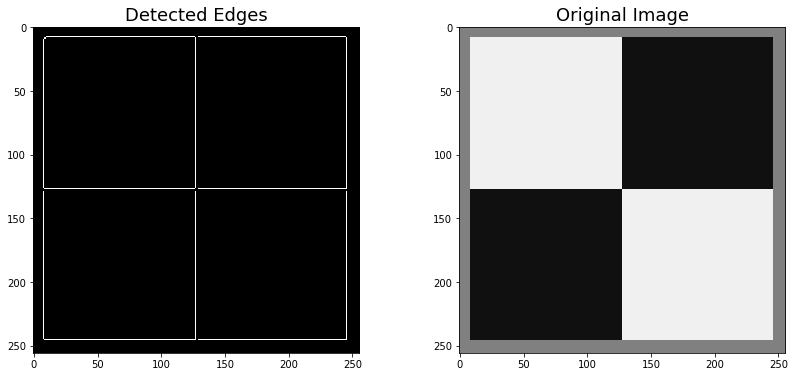

In [6]:
# Edge Detection
img0_canny = CannyOperator(img0, 100, 200)
img0_canny.operate()
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Detected Edges')
ax[0].imshow(img0_canny.img_edges)
ax[1].set_title('Original Image')
ax[1].imshow(img0);

---
## 2. Hough Line Detector

In [7]:
class HoughLines:
    def __init__(self, img, rho_res=1.0, theta_res=np.pi/180, thresh=100):
        # Image
        self.img = img
        # Tunable params
        self.rho_res = rho_res
        self.theta_res = theta_res
        self.thresh = thresh
        # Limits
        self.rho_min = -self.img.shape[1]
        self.rho_max = np.sqrt(self.img.shape[0]**2 + self.img.shape[1]**2)
        return
    
    def accumulate(self):
        # Ranges
        num_theta = int(round(np.pi / self.theta_res))
        num_rho = int(round((self.rho_max-self.rho_min) / self.rho_res)) + 1
        self.accum = np.zeros((num_rho, num_theta))
        # Each point votes for multiple lines
        for y, row in enumerate(self.img):
            for x, val in enumerate(row):
                if val > 0:
                    for theta_ix in range(num_theta):
                        theta = theta_ix * self.theta_res
                        rho = x*np.cos(theta) + y*np.sin(theta)
                        rho_ix = int(round((rho-self.rho_min) / self.rho_res))
                        self.accum[rho_ix, theta_ix] += 1
        self.lines = None
        return self.accum
    
    def extract_lines(self):
        # Take only local maximas > threshold
        self.lines = []
        num_rho, num_theta = self.accum.shape
        for rho_ix in range(1, num_rho-1):
            for theta_ix in range(num_theta):
                if self.accum[rho_ix, theta_ix] > self.thresh:
                    rho = self.rho_min + self.rho_res*rho_ix
                    # (rho, theta) space wraps around inversely at the theta edges
                    # Edge points
                    if theta_ix == 0:
                        rho_left = int(round((-rho-self.rho_min) / self.rho_res))
                        left = self.accum[rho_left, -1]
                        right = self.accum[rho_ix, theta_ix+1]
                    elif theta_ix == num_theta-1:
                        rho_right = int(round((-rho-self.rho_min) / self.rho_res))
                        left = self.accum[rho_ix, theta_ix-1]
                        right = self.accum[rho_right, 0]
                    # Normal point
                    else:
                        left = self.accum[rho_ix, theta_ix-1]
                        right = self.accum[rho_ix, theta_ix+1]

                    if self.accum[rho_ix, theta_ix] > self.accum[rho_ix-1, theta_ix] and \
                    self.accum[rho_ix, theta_ix] >= self.accum[rho_ix+1, theta_ix] and \
                    self.accum[rho_ix, theta_ix] > left and \
                    self.accum[rho_ix, theta_ix] >= right:
                        theta = self.theta_res*theta_ix
                        self.lines.append((rho, theta))
        return self.lines
    
    def plot_accum(self, ax):
        # Accumulator
        im = ax.imshow(self.accum, aspect='auto', origin='lower', extent=[0, np.pi, self.rho_min, self.rho_max])
        # Fix x,y axes
        ax.set_ylim(self.rho_min, self.rho_max)
        ax.set_xlim(0, np.pi)
        if self.lines:
            # Mark detected lines
            rho, theta = zip(*self.lines)
            ax.scatter(theta, rho, s=80, facecolors='none', edgecolors='r')
        ax.set_title('Accumulator')
        # Create colorbar
        plt.colorbar(im)
        return
    
    def plot_lines(self, ax):
        # Lines
        ax.set_title('Detected Lines')
        # Fix x,y axes
        ax.set_ylim(self.img.shape[0], 0)
        ax.set_xlim(0, self.img.shape[1])
        xrange = range(self.img.shape[1])
        yrange = range(self.img.shape[0])
        # Plot each line
        for rho, theta in self.lines:
            ax.plot(*HoughLines.get_line_points(rho, theta, xrange, yrange), 'g')
        return
    
    @staticmethod
    def get_line_points(rho, theta, xrange, yrange=0):
        if np.sin(theta):
            # Normal line
            fx = (rho - xrange*np.cos(theta)) / np.sin(theta)
            return xrange, fx
        else:
            # Vertical line
            fy = (rho - yrange*np.sin(theta)) / np.cos(theta)
            return fy, yrange

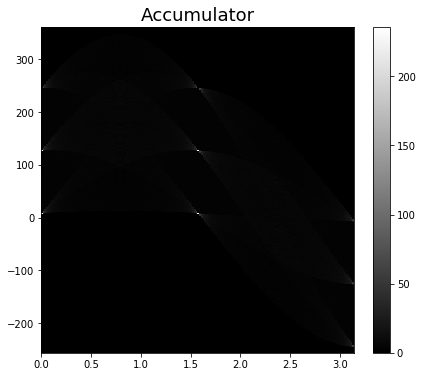

In [8]:
img0_houghobj = HoughLines(img0_canny.img_edges)
@interact(rho_res=(1, 10))
def img0_hough_accum(rho_res=1):
    # Hough
    img0_houghobj.rho_res = rho_res
    img0_houghobj.accumulate()
    # Plot accumulator
    fig, ax = plt.subplots(figsize=(7, 6))
    img0_houghobj.plot_accum(ax)
    return

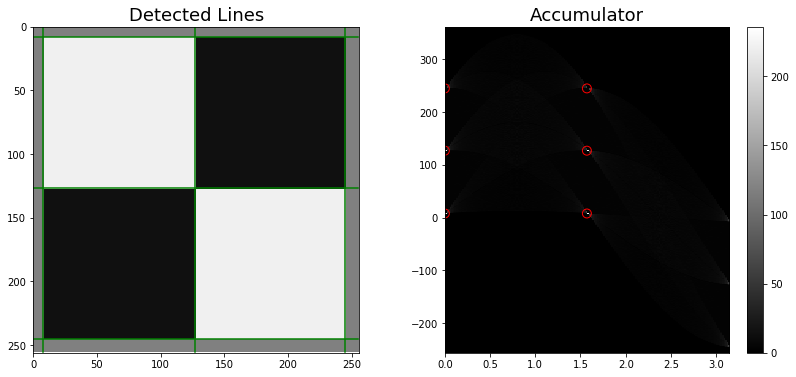

In [9]:
@interact(thresh=(100, 500))
def img0_hough(thresh=200):
    img0_houghobj.thresh = thresh
    # Get lines from accumulator matrix
    img0_houghobj.extract_lines()
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img0)
    img0_houghobj.plot_lines(ax[0])    
    img0_houghobj.plot_accum(ax[1])
    return

The bin sizes for the accumulator used are (1px, pi/180 rad). These were picked to get maximum accuracy.

---
## 3. Edge Detection with Noise

In [10]:
# Load Noisy image
img0n = cv2.imread('ps1-input0-noise.png')
# OpenCV BGR to RGB
img0n = img0n[:,:,::-1]

### a. Gaussian Filter

In [11]:
class GaussianFilter:
    def __init__(self, img, ksize=1, sigma=1.0):
        # Params
        self.img = img
        self.kernel_size = ksize
        self.sigma = sigma
    def blur(self):
        self.img_blur = cv2.GaussianBlur(self.img, (self.kernel_size, self.kernel_size), self.sigma)
        return self.img_blur
    def plot_comparison(self):
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(self.img_blur)
        ax[0].set_title('Blurred Image')
        ax[1].imshow(self.img)
        ax[1].set_title('Original Image')
        return

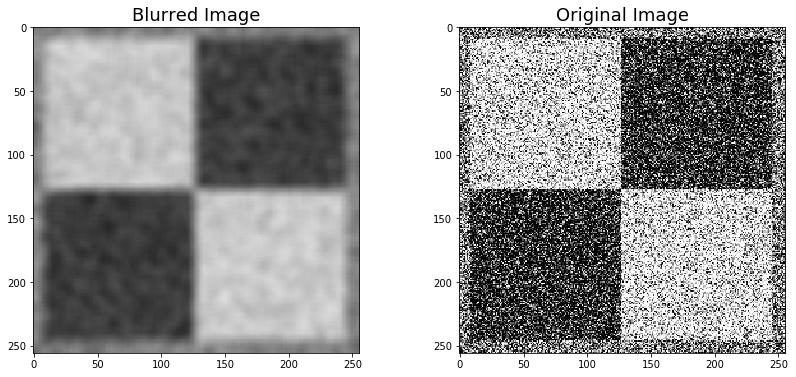

In [12]:
img0n_blurobj = GaussianFilter(img0n)
@interact(ksize=(1,25,2), sigma=(0.1,5.0,0.1))
def img0_gaussian_blur(ksize=13, sigma=4.2):
    # Params
    img0n_blurobj.kernel_size = ksize
    img0n_blurobj.sigma = sigma
    # Add blur
    img0n_blurobj.blur()
    # Plot
    img0n_blurobj.plot_comparison()
    return

### b. Edge Operator

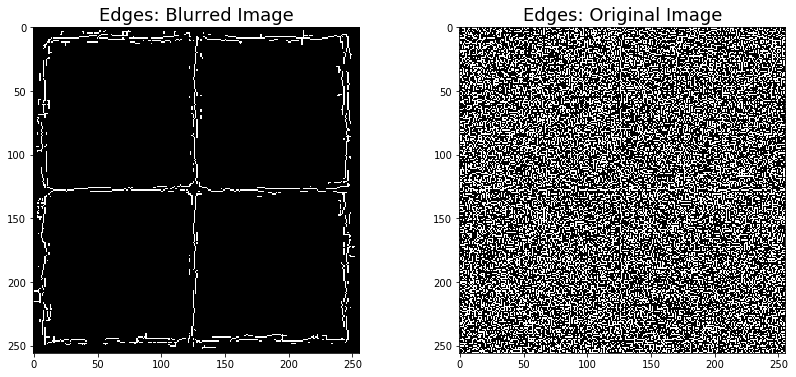

In [13]:
img0n_cannyobj = CannyOperator(None)
@interact(thresh_low=(0,255), thresh_high=(0,255))
def img0_canny(thresh_low=50, thresh_high=65):
    # Load image
    img0n_cannyobj.img = img0n_blurobj.img_blur
    # Canny edge operator
    img0n_cannyobj.thresh_low = thresh_low
    img0n_cannyobj.thresh_high = thresh_high
    img0n_cannyobj.operate()
    # Edge detection on original image
    img0n_edges = cv2.Canny(img0n, 50, 65)
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img0n_cannyobj.img_edges)
    ax[0].set_title('Edges: Blurred Image')
    ax[1].imshow(img0n_edges)
    ax[1].set_title('Edges: Original Image')
    return

### c. Hough Line detection

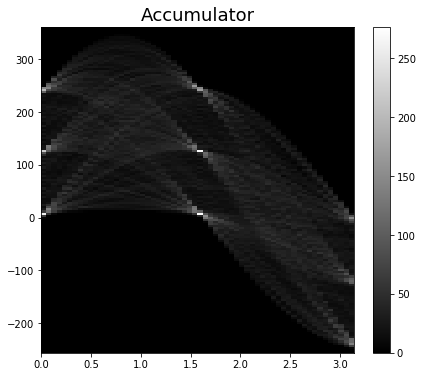

In [14]:
img0n_houghobj = HoughLines(img0n_cannyobj.img_edges)
@interact(rho_res=(1, 10), theta_res_deg=(0.5, 20.0, 0.5))
def img0n_hough_accum(rho_res=4.0, theta_res_deg=3.0):
    # Hough
    img0n_houghobj.rho_res = rho_res
    img0n_houghobj.theta_res = theta_res_deg * np.pi/180
    img0n_houghobj.accumulate()
    # Plot accumulator
    fig, ax = plt.subplots(figsize=(7, 6))
    img0n_houghobj.plot_accum(ax)
    return

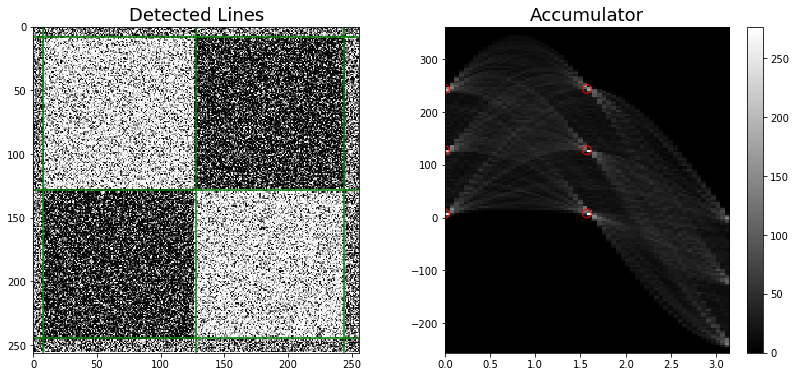

In [15]:
@interact(thresh=(50, 400))
def img0n_hough(thresh=170):
    # Params
    img0n_houghobj.thresh = thresh
    # Get lines from accumulator matrix
    img0n_houghobj.extract_lines()
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img0n)
    img0n_houghobj.plot_lines(ax[0])    
    img0n_houghobj.plot_accum(ax[1])
    return

The sigma of the Gaussian filter is large to filter out the noise. The thresholds of the Canny operator are low to compensate for a noisy input and to get a clear edge image. For the hough transform, the bin sizes were increased to tolerate small errors in the edge image. The threshold was adjusted accordingly to get the lines.

---
## 4. Edge Detection: Second Image

In [16]:
# Load Noisy image
img1 = cv2.imread('ps1-input1.jpg')
# OpenCV BGR to RGB
img1 = img1[:,:,::-1]

### a. Gaussian Filter

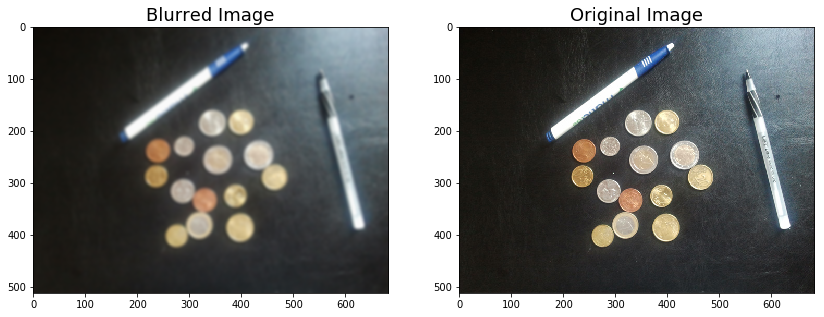

In [17]:
img1_blurobj = GaussianFilter(img1)
@interact(ksize=(1,25,2), sigma=(0.1,5.0,0.1))
def img1_gaussian_blur(ksize=11, sigma=3.0):
    # Params
    img1_blurobj.kernel_size = ksize
    img1_blurobj.sigma = sigma
    # Add blur
    img1_blurobj.blur()
    # Plot
    img1_blurobj.plot_comparison()
    return

### b. Edge Operator

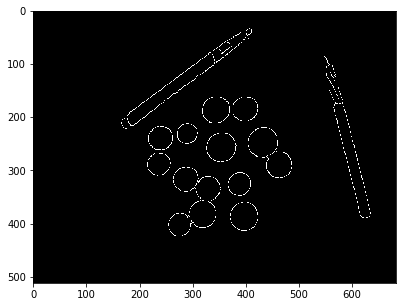

In [18]:
img1_cannyobj = CannyOperator(None)
@interact(thresh_low=(0,255), thresh_high=(0,255))
def img1_canny(thresh_low=50, thresh_high=100):
    # Load image
    img1_cannyobj.img = img1_blurobj.img_blur
    # Canny
    img1_cannyobj.thresh_low = thresh_low
    img1_cannyobj.thresh_high = thresh_high
    img1_cannyobj.operate()
    # Plot
    plt.figure(figsize=(6.5, 6))
    plt.imshow(img1_cannyobj.img_edges)
    return

### c. Hough Line detection

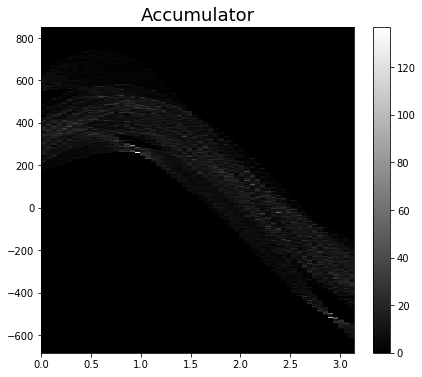

In [19]:
img1_houghobj = HoughLines(img1_cannyobj.img_edges)
@interact(rho_res=(1, 10), theta_res_deg=(0.5, 20.0, 0.5))
def img1_hough_accum(rho_res=1.0, theta_res_deg=3.0):
    # Hough
    img1_houghobj.rho_res = rho_res
    img1_houghobj.theta_res = theta_res_deg * np.pi/180
    img1_houghobj.accumulate()
    # Plot accumulator
    fig, ax = plt.subplots(figsize=(7, 6))
    img1_houghobj.plot_accum(ax)
    return

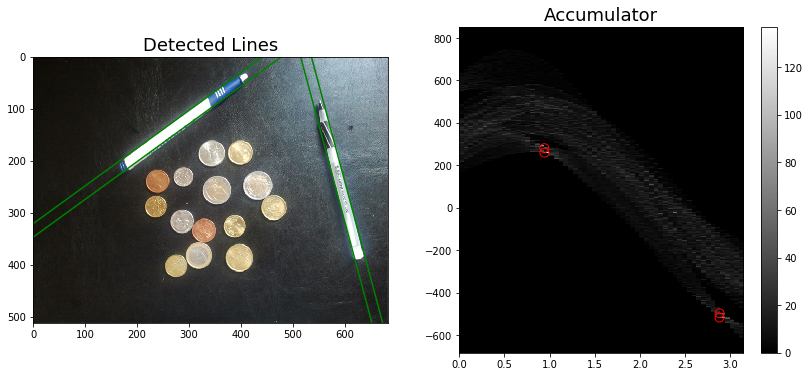

In [20]:
@interact(thresh=(50, 200))
def img1_hough(thresh=80):
    # Params
    img1_houghobj.thresh = thresh
    # Get lines from accumulator matrix
    img1_houghobj.extract_lines()
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1)
    img1_houghobj.plot_lines(ax[0])    
    img1_houghobj.plot_accum(ax[1])
    return

The bin size of theta was increased to make sure there weren't multiple lines at slightly different angles for the same edge.

---
## 5. Hough Circle Detection

In [21]:
class HoughCircles:
    def __init__(self, img, r_min, r_max, r_res=1.0, xy_res=1.0, thresh=100):
        # Image
        self.img = img
        # Tunable params
        self.r_min = r_min
        self.r_max = r_max
        self.r_res = r_res
        self.xy_res = xy_res
        self.thresh = thresh
        return

    def accumulate(self):
        # Limits
        self.x_min = -self.r_max
        self.x_max = self.img.shape[1] + self.r_max
        self.y_min = -self.r_max
        self.y_max = self.img.shape[0] + self.r_max
        # Dimensions
        num_y = int(round((self.y_max-self.y_min) / self.xy_res))
        num_x = int(round((self.x_max-self.x_min) / self.xy_res))
        num_r = int(round((self.r_max-self.r_min) / self.r_res))
        self.accum = np.zeros((num_y, num_x, num_r))
        # Each point votes for multiple circles
        for y, row in enumerate(self.img):
            for x, val in enumerate(row):
                if val > 0:
                    for r_ix in range(num_r):
                        r = self.r_min + self.r_res*r_ix
                        for theta in np.arange(0, 2*np.pi, np.pi/180):
                            x_center = x + r*np.cos(theta)
                            y_center = y + r*np.sin(theta)

                            x_ix = int(round((x_center-self.x_min) / self.xy_res))
                            y_ix = int(round((y_center-self.y_min) / self.xy_res))

                            self.accum[y_ix, x_ix, r_ix] += 1
        self.circles = None
        return self.accum

    def extract_circles(self):
        # Take only local maximas > threshold
        self.circles = []
        num_y, num_x, num_r = self.accum.shape
        for y_ix in range(1, num_y-1):
            for x_ix in range(1, num_x-1):
                for r_ix in range(1, num_r-1):
                    if self.accum[y_ix, x_ix, r_ix] > self.thresh and \
                    self.accum[y_ix, x_ix, r_ix] > self.accum[y_ix-1, x_ix, r_ix] and \
                    self.accum[y_ix, x_ix, r_ix] > self.accum[y_ix+1, x_ix, r_ix] and \
                    self.accum[y_ix, x_ix, r_ix] > self.accum[y_ix, x_ix-1, r_ix] and \
                    self.accum[y_ix, x_ix, r_ix] > self.accum[y_ix, x_ix+1, r_ix] and \
                    self.accum[y_ix, x_ix, r_ix] > self.accum[y_ix, x_ix, r_ix-1] and \
                    self.accum[y_ix, x_ix, r_ix] > self.accum[y_ix, x_ix, r_ix+1]:
                        x = self.x_min + self.xy_res*x_ix
                        y = self.y_min + self.xy_res*y_ix
                        r = self.r_min + self.r_res*r_ix
                        self.circles.append((x, y, r))
        return self.circles
    
    def filter_concentric(self, min_dist=10):
        # Filter out circles of similar radius which are too close
        out_circles = []
        self.extract_circles()
        flagged = [False] * len(self.circles)
        for i1, (x1, y1, r1) in enumerate(self.circles):
            for i2, (x2, y2, r2) in enumerate(self.circles[i1+1:]):
                if not flagged[i1+i2+1]:
                    if np.sqrt((x2-x1)**2 + (y2-y1)**2) < min_dist and abs(r2-r1) < min_dist:
                        # Circle 1
                        x1_ix = int(round((x1-self.x_min) / self.xy_res))
                        y1_ix = int(round((y1-self.y_min) / self.xy_res))
                        r1_ix = int(round((r1-self.r_min) / self.r_res))
                        # Circle 2
                        x2_ix = int(round((x2-self.x_min) / self.xy_res))
                        y2_ix = int(round((y2-self.y_min) / self.xy_res))
                        r2_ix = int(round((r2-self.r_min) / self.r_res))
                        if self.accum[y1_ix, x1_ix, r1_ix] > self.accum[y2_ix, x2_ix, r2_ix]:
                            flagged[i1+i2+1] = True
                        else:
                            flagged[i1] = True
                            break
            if not flagged[i1]:
                out_circles.append((x1, y1, r1))
        self.circles = out_circles
        return

    def plot_accum_slice(self, ax, r_slice_ix):
        # Plot a slice of the accumulator
        im = ax.imshow(self.accum[:, :, r_slice_ix], extent=[self.x_min, self.x_max, self.y_max, self.y_min])
        # Fix x,y axes
        ax.set_xlim(self.x_min, self.x_max)
        ax.set_ylim(self.y_max, self.y_min)
        for x, y, r in self.circles:
            r_ix = int(round((r-self.r_min) / self.r_res))
            if r_ix == r_slice_ix:
                # Mark detected circles
                ax.scatter(x, y, s=80, facecolors='none', edgecolors='r')
        ax.set_title('Accumulator')
        # Create colorbar
        plt.colorbar(im)
        return


    def plot_circles(self, ax):
        ax.set_title('Detected Circles')
        # Fix x,y axes
        ax.set_ylim(self.img.shape[0], 0)
        ax.set_xlim(0, self.img.shape[1])
        # Plot each circle
        for x, y, r in self.circles:
            circ = plt.Circle((x, y), r, color='g', fill=False)
            ax.add_patch(circ)
        return

In [22]:
# Radius Limits
r_min = 15.0
r_max = 30.0
img1_houghc_obj = HoughCircles(img1_cannyobj.img_edges, r_min, r_max)
# Build hough circle accumulator
@interact(r_res=(1, 10), xy_res=(1, 10))
def img1_houghc_accum(r_res=2, xy_res=1):
    img1_houghc_obj.r_res = r_res
    img1_houghc_obj.xy_res = xy_res
    img1_houghc_obj.accumulate()
    return

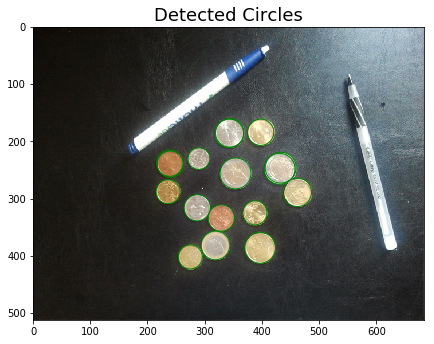

In [23]:
# Select circles by adjusting threshold
@interact(thresh=(100, 300))
def img1_houghc(thresh=150):
    img1_houghc_obj.thresh = thresh
    # Get circles from accumulator matrix
    img1_houghc_obj.extract_circles()
    # Plot
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.imshow(img1)
    img1_houghc_obj.plot_circles(ax)
    return

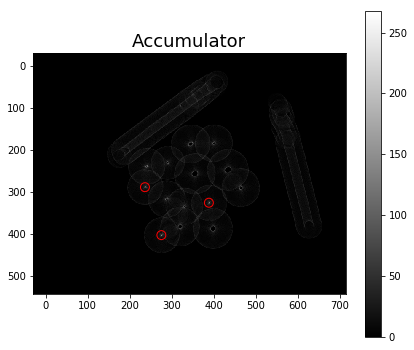

In [24]:
# Plot slice of accumulator
r_max_ix = img1_houghc_obj.accum.shape[2] - 1
@interact(r_slice_ix=(0, r_max_ix))
def img1_houghc(r_slice_ix=3):
    # Plot
    fig, ax = plt.subplots(figsize=(7, 6))
    img1_houghc_obj.plot_accum_slice(ax, r_slice_ix)
    return

The bin size for the radius was increased to make the computation more efficient.

---
## 6. Clutter Image

In [25]:
# Load Noisy image
img2 = cv2.imread('ps1-input2.jpg')
# OpenCV BGR to RGB
img2 = img2[:,:,::-1]

### a. Line Detection

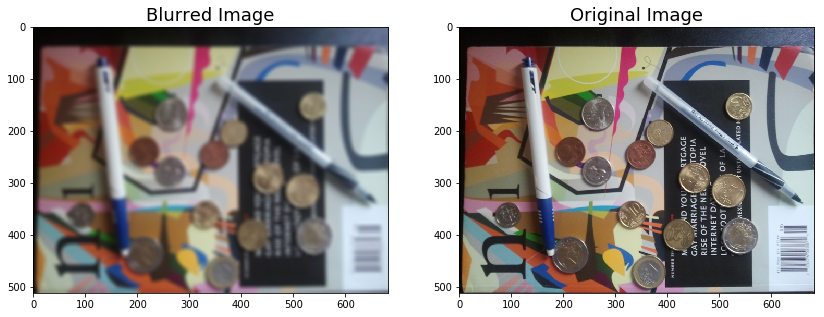

In [26]:
# Smoothing
img2_blurobj = GaussianFilter(img2)
@interact(ksize=(1,25,2), sigma=(0.1,5.0,0.1))
def img2_gaussian_blur(ksize=13, sigma=4.0):
    img2_blurobj.kernel_size = ksize
    img2_blurobj.sigma = sigma
    # Add blur
    img2_blurobj.blur()
    # Plot
    img2_blurobj.plot_comparison()
    return

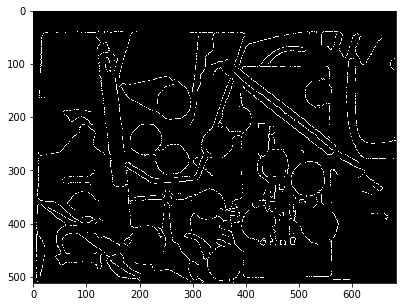

In [27]:
# Edge Detection
img2_cannyobj = CannyOperator(None)
@interact(thresh_low=(0,255), thresh_high=(0,255))
def img2_canny(thresh_low=0, thresh_high=90):
    img2_cannyobj.img = img2_blurobj.img_blur
    # Canny edge operator
    img2_cannyobj.thresh_low = thresh_low
    img2_cannyobj.thresh_high = thresh_high
    img2_cannyobj.operate()
    # Plot
    plt.figure(figsize=(6.5, 6))
    plt.imshow(img2_cannyobj.img_edges)
    return

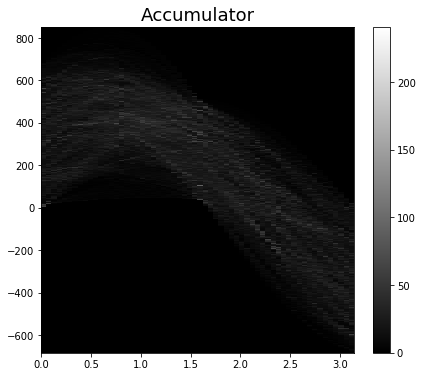

In [28]:
# Build hough line accumulator
img2_houghobj = HoughLines(img2_cannyobj.img_edges)
@interact(rho_res=(1, 5), theta_res_deg=(1, 5))
def img1_hough_accum(rho_res=1.0, theta_res_deg=3.0):
    img2_houghobj.rho_res = rho_res
    img2_houghobj.theta_res = theta_res_deg * np.pi/180
    img2_houghobj.accumulate()
    # Plot accumulator
    fig, ax = plt.subplots(figsize=(7, 6))
    img2_houghobj.plot_accum(ax)
    return

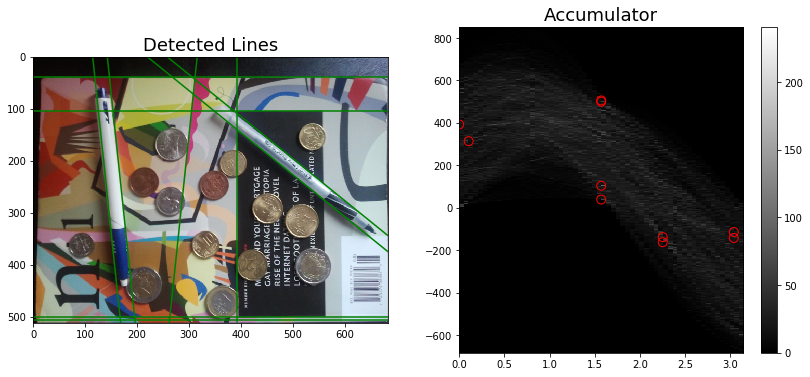

In [29]:
# Adjust threshold to select lines
@interact(thresh=(50, 200))
def img2_hough(thresh=90):
    img2_houghobj.thresh = thresh
    # Get lines from accumulator matrix
    img2_houghobj.extract_lines()
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img2)
    img2_houghobj.plot_lines(ax[0])    
    img2_houghobj.plot_accum(ax[1])
    return

### b. Problems
The image consists of a lot of edges which are not the boundaries of the pens. These edges are detected as well and cannot be simply filtered out using thresholding.

### c. Finding boundaries of pen

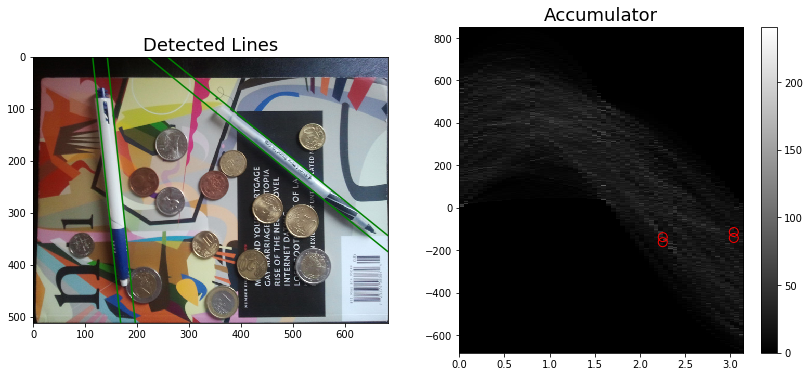

In [30]:
# Only select the lines which are parallel and have separation which lies in a particular range
def filter_parallel(houghlines_obj, dist_min=10, dist_max=50, theta_thresh=2*np.pi/180):
    out_lines = []
    houghlines_obj.extract_lines()
    for i, (rho1, theta1) in enumerate(houghlines_obj.lines):
        for (rho2, theta2) in houghlines_obj.lines[i+1:]:
            if abs(theta1 - theta2) < theta_thresh and dist_min < abs(rho1 - rho2) and abs(rho1 - rho2) < dist_max:
                out_lines.append((rho1, theta1))
                out_lines.append((rho2, theta2))
    houghlines_obj.lines = out_lines
    return

filter_parallel(img2_houghobj)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img2)
img2_houghobj.plot_lines(ax[0])    
img2_houghobj.plot_accum(ax[1])

---
## 7. Clutter Image: Circles
### a. Hough circle detector

In [31]:
# Radius Limits
r_min = 20.0
r_max = 40.0
img2_houghc_obj = HoughCircles(img2_cannyobj.img_edges, r_min, r_max, r_res=1, xy_res=1)
img2_houghc_obj.accumulate();

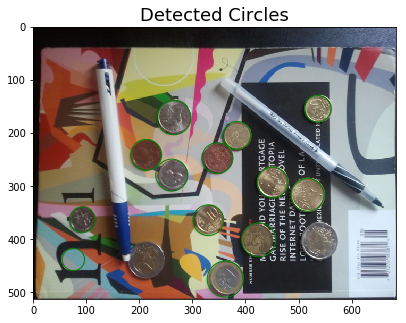

In [32]:
# Adjust threshold to detect circles
@interact(thresh=(50, 200))
def img2_houghc(thresh=100):
    img2_houghc_obj.thresh = thresh
    # Get circles from accumulator matrix
    img2_houghc_obj.extract_circles()
    img2_houghc_obj.filter_concentric(min_dist=10)
    # Plot
    fig, ax = plt.subplots(figsize=(6.5, 6))
    ax.imshow(img2)
    img2_houghc_obj.plot_circles(ax)
    return

### b. False Alarms
A naive implementation of the hough transform for circles resulted in there being multiple detected circles for each coin. To get rid of these, a restriction was added that nearby circles cannot have approximately the same radius.  
Other false alarms include the circle going through the letter 'n'. One way to get rid of them is to add a restriction to only detect complete circles and not occluded ones.  
In order to ensure that all the coins are detected, we need a better edge image. 

---
## 8. Distorted Image

In [33]:
# Load image
img3 = cv2.imread('ps1-input3.jpg')
# OpenCV BGR to RGB
img3 = img3[:,:,::-1]

### a. Line and Circle Detection

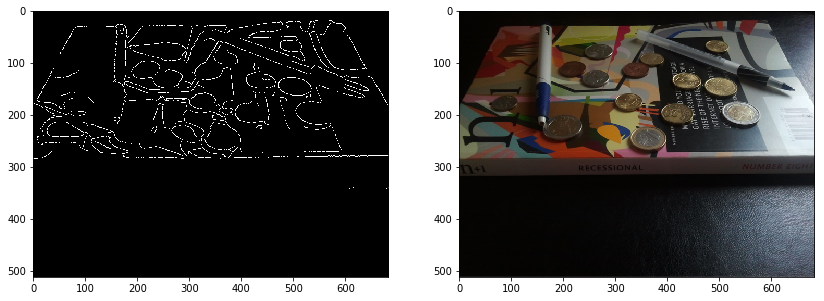

In [34]:
# Edge detection
img3_canny = CannyOperator(None)
@interact(ksize=(1,25,2), sigma=(0.1,5.0,0.1), thresh_low=(0,255), thresh_high=(0,255))
def img3_edges(ksize=13, sigma=3.0, thresh_low=40, thresh_high=70):
    # Add blur
    img3_blurobj = GaussianFilter(img3, ksize, sigma)
    img3_blurobj.blur()
    img3_canny.img = img3_blurobj.img_blur
    # Canny edge operator
    img3_canny.thresh_low = thresh_low
    img3_canny.thresh_high = thresh_high
    img3_canny.operate()
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img3_canny.img_edges)
    ax[1].imshow(img3)
    return

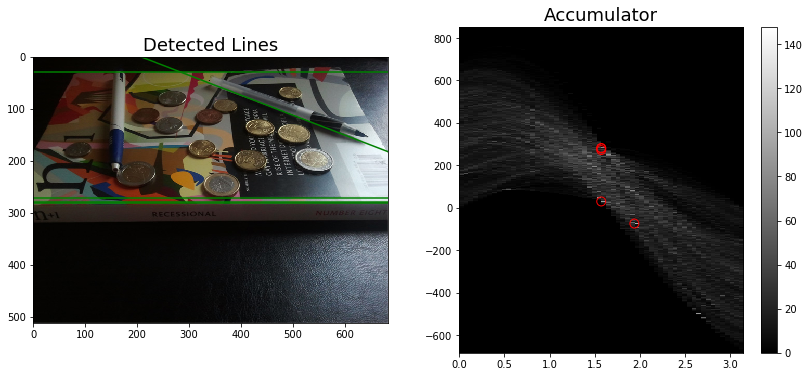

In [35]:
# Hough Lines
img3_houghobj = HoughLines(img3_canny.img_edges)
@interact(rho_res=(1, 5), theta_res_deg=(1, 5), thresh=(50, 200))
def img1_hough_accum(rho_res=1.0, theta_res_deg=3.0, thresh=100):
    img3_houghobj.img = img3_canny.img_edges
    img3_houghobj.rho_res = rho_res
    img3_houghobj.theta_res = theta_res_deg * np.pi/180
    img3_houghobj.accumulate()
    img3_houghobj.thresh = thresh
    img3_houghobj.extract_lines()
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img3)
    img3_houghobj.plot_lines(ax[0])    
    img3_houghobj.plot_accum(ax[1])
    return

In [36]:
# Radius Limits
r_min = 20.0
r_max = 40.0
# Build hough circle accumulator
img3_houghc_obj = HoughCircles(img3_canny.img_edges, r_min, r_max, r_res=1, xy_res=1)
img3_houghc_obj.accumulate();

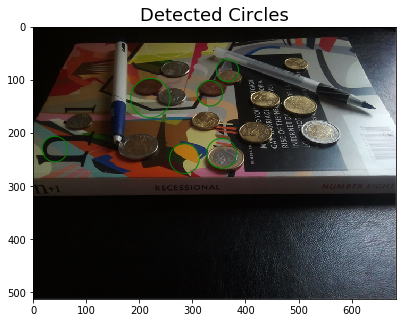

In [37]:
# Adjust threshold to detect circles
@interact(thresh=(50, 200))
def img3_houghc(thresh=100):
    img3_houghc_obj.thresh = thresh
    # Get circles from accumulator matrix
    img3_houghc_obj.filter_concentric(min_dist=30)
    # Plot
    fig, ax = plt.subplots(figsize=(6.5, 6))
    ax.imshow(img3)
    img3_houghc_obj.plot_circles(ax)
    return

### b. Problems
The circles are now ellipses in the image due to the change in perspective. The hough circle detection does not work. We can extend the hough transform to ellipses by adding more parameters.

### c. Fixing Circle problem

In [38]:
## TODO: Implement Hough Ellipse